For this challenge, we will classify images of dogs and cats. We will use Tensorflow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time.


---




The structure of the dataset files that are downloaded looks like this :
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

**Setup and imports**

In [2]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

2022-11-22 17:25:24.270260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 17:25:24.270385: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


**Dataset**

In [3]:
# Get project files
#!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
#!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

**Data preprocessing**
<p>Before we continue we have to preprocess image dataset. This means just applying some prior transformations to our data. In this case we'll simplyscale all our grayscale pixel value (0-255) to be between 0 and 1. We do this because smaller valueswill make it easier for our model to process our values.</p>
After you run the code, the output should look like this:
<ul>
<li>Found 2000 images belonging to 2 classes.</li>
    <li>Found 1000 images belonging to 2 classes.</li>
<li>Found 50 images belonging to 1 classes.</li>
</ul>

In [4]:
train_image_generator      = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator       = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    directory=PATH+'/train',
    classes=['cats','dogs'],
    batch_size=batch_size,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='sparse'
)
val_data_gen = validation_image_generator.flow_from_directory(
    directory=PATH+'/validation',
    classes=['cats','dogs'],
    batch_size=batch_size,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='sparse'
)
test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,
    classes=['test'],
    batch_size=batch_size,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='sparse',
    shuffle=False,
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


<b>Data visualization utils</b>
<p>The `plotImages` function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional.</p>

In [5]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

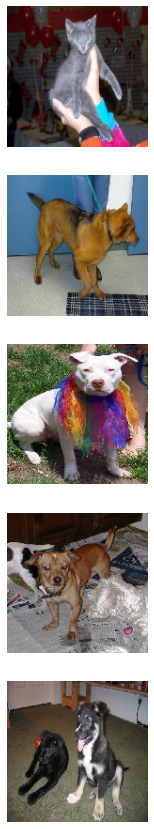

In [6]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

<b>Let increase our training dataset</b>

We recreate the `train_image_generator` using `ImageDataGenerator`. 
<p>
Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.
</p>

So we add 4-6 random transformations as arguments to `ImageDataGenerator`.


In [7]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

Here `train_data_gen` is created just like before but with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


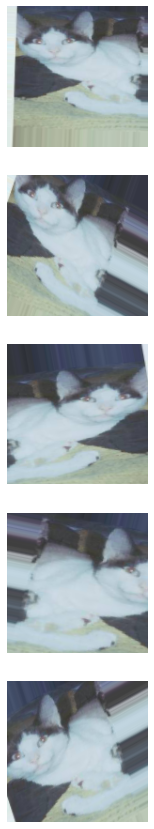

In [8]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

# Let get a look
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

<b>Building the model</b>

In [9]:
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.2)),
model.add(Flatten())
model.add(Dense(128, activation='relu')),
model.add(Dense(64, activation='relu'))
model.add(Dense(2))

model.summary()

2022-11-22 17:27:08.421146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 17:27:08.421210: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 17:27:08.421332: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (genereux-Satellite-C55-B): /proc/driver/nvidia/version does not exist


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        18464     
_________________________________________________________________
dropout (Dropout)            (None, 34, 34, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

**Compile the model**

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Training the model**

Use the `fit` method on your `model` to train the network. Make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

In [ ]:
# steps_per_epoch  = len(train_data_gen) // batch_size
# validation_steps = len(val_data_gen) // batch_size
history = model.fit(train_data_gen, epochs=epochs, validation_data=val_data_gen)

2022-11-22 17:27:43.087891: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-22 17:27:43.107626: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1795865000 Hz


Epoch 1/15


2022-11-22 17:27:48.173444: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1435500544 exceeds 10% of free system memory.
2022-11-22 17:27:50.977869: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 358875136 exceeds 10% of free system memory.
2022-11-22 17:28:12.830578: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 358875136 exceeds 10% of free system memory.
2022-11-22 17:28:23.843410: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 717750272 exceeds 10% of free system memory.
2022-11-22 17:28:23.843580: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1435500544 exceeds 10% of free system memory.


**Accuracy and loss of the model**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<b>Prediction</b>

Now it is time to use your model to predict whether a brand new image is a cat or a dog.

In this final cell, get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` should be a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After your run the cell, you should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

In [ ]:
predictions = model.predict(test_data_gen)
predictions[:,0]
plotImages(test_data_gen, predictions)

<b>Final Assessment</b>

Run this final cell to see if you passed the challenge or if you need to keep trying.

In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")